In [2]:
#라이브러리 로드
import numpy as np
import pandas as pd
import cv2
import os
import random
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

from colorsys import rgb_to_hsv
from keras.preprocessing.image import load_img

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

## 0. 상숫값 및 경로 설정

In [6]:
image_dir = 'test1/' #1.이미지 불러오기 - 이미지 폴더 디렉토리
sample_ratio = 1 #1.이미지 불러오기 - 샘플링 비율
pca_threshold = 0.99 #3. PCA - 적합한 차원 수 찾기
save_dir = 'saves2/' #6. 데이터 저장 - 데이터 저장 디렉토리

## 1. 이미지 불러오기

In [7]:
# 파일명을 담는 리스트
file_names = []

with os.scandir(image_dir) as files:
    for file in files:
        # .jpg .png 등 확장자명이 'g'로 끝나는 파일들 모두 읽기
        if file.name.endswith('g'):
            file_names.append(image_dir + file.name)
            
# 샘플링 수행 ()
if sample_ratio < 1:
    file_names = random.sample(file_names, int(len(file_names) * sample_ratio))

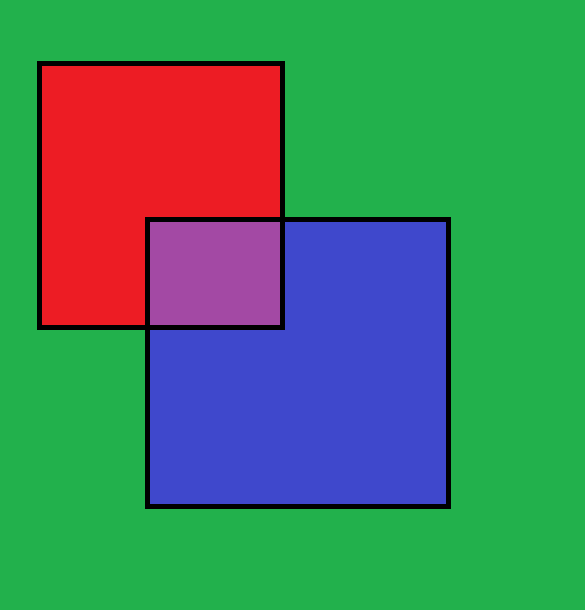

In [8]:
img = load_img(file_names[0])
img

## 2. RGB-HSV 데이터 추출

In [9]:
def extract_data(file_name, image_size = (224, 224)):
    #이미지 불러오기 및 np array로 변경
    img = load_img(file_name, target_size = image_size)
    img = np.array(img)
    img = img.reshape(image_size[0] * image_size[1], 3)
    
    #hsv 데이터 추출, 병합
    hsv_data = []
    for pixel in img:
        hsv_data.append(rgb_to_hsv(pixel[0] / 255, pixel[1] / 255, pixel[2] / 255))
    return np.concatenate((img / 255, hsv_data), axis = 1)

## 3. PCA - 적합한 차원 수 찾기

In [10]:
# 가장 적합한 차원 수를 찾기 위한 과정, explained_variance_ratio_ > 0.99 로 잡음

def pca_test(data, threshold):
    pca = PCA(n_components = len(data[0]), random_state = 2021)
    pca.fit_transform(data)
    
    ratio = np.cumsum(pca.explained_variance_ratio_)
    d = np.argmax(ratio >= threshold) + 1    
    return (d, ratio[d - 1])

In [11]:
data = extract_data(file_names[0])
pca_component = pca_test(data, pca_threshold)
pca_component

(4, 1.0)

## 4. 클러스터링 수행

In [12]:
def clustering_data(data, pca_components = 5, target_cluster = 20):
    pca = PCA(n_components=pca_components, random_state=22)
    x = pca.fit_transform(data)
    
    kmeans = KMeans(n_clusters=target_cluster, random_state=22)
    kmeans.fit(x)
    
    return np.concatenate((data, kmeans.labels_.reshape(-1, 1)), axis = 1)

In [13]:
clu_data = clustering_data(data, pca_component[0])
clu_data[0:5]

<ipython-input-12-653b97794f29>:6: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  kmeans.fit(x)


array([[ 0.13333333,  0.69411765,  0.29803922,  0.38228438,  0.8079096 ,
         0.69411765,  6.        ],
       [ 0.13333333,  0.69411765,  0.29803922,  0.38228438,  0.8079096 ,
         0.69411765, 11.        ],
       [ 0.13333333,  0.69411765,  0.29803922,  0.38228438,  0.8079096 ,
         0.69411765,  7.        ],
       [ 0.13333333,  0.69411765,  0.29803922,  0.38228438,  0.8079096 ,
         0.69411765,  8.        ],
       [ 0.13333333,  0.69411765,  0.29803922,  0.38228438,  0.8079096 ,
         0.69411765,  9.        ]])

## 5. 클러스터 그룹 별 개수 세기

In [14]:
def grouping_clusters(data):
    table = pd.DataFrame(data, columns = ['R','G','B','H','S','V','Cluster'])
    gr = table.groupby('Cluster')
    gr = pd.concat([gr.mean(), gr['R'].count().rename('Count')], axis = 1)
    gr.sort_values(by = 'Count', ascending = False, inplace = True)
    
    #scaler = MinMaxScaler()
    #gr[['Count']] = scaler.fit_transform(gr[['Count']])
    total = gr['Count'].sum().sum()
    gr['Count'] = gr['Count'].apply(lambda x : x / total)
    return gr

In [15]:
gr_data = grouping_clusters(clu_data)
gr_data.head(5)

,R,G,B,H,S,V,Count
Cluster,,,,,,,
9.0,0.133333,0.694118,0.298039,0.382284,0.807910,0.694118,0.606286
2.0,0.247059,0.282353,0.800000,0.656028,0.691176,0.800000,0.193599
1.0,0.929412,0.109804,0.141176,0.993620,0.881857,0.929412,0.132653
4.0,0.639216,0.286275,0.643137,0.831502,0.554878,0.643137,0.036870
3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030513


## 6. 데이터 시각화

<BarContainer object of 9 artists>

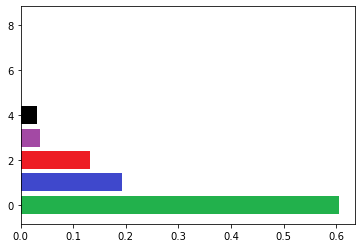

In [24]:
plt.barh(range(len(gr_data)), gr_data['Count'].values, color = gr_data.iloc[:, 0:3].values)

## 7. 데이터 저장

In [54]:
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

In [55]:
def save_data(data, file_name, save_dir):
    try:
        save_name = save_dir + file_name.rsplit('.')[0].rsplit('/')[-1] + ".csv"
        data.to_csv(save_name)
    except:
        createFolder(save_dir)

In [56]:
save_data(gr_data, file_names[0], "saves/")

## 8. 전체 데이터셋 수행

In [57]:
for file_name in tqdm(file_names):
    data = extract_data(file_name)
    pca_component = pca_test(data, pca_threshold)
    clu_data = clustering_data(data, pca_component[0])
    gr_data = grouping_clusters(clu_data)
    save_data(gr_data, file_name, save_dir)

100%|████████████████████████████████████████████████████████████████████████████████| 544/544 [18:40<00:00,  2.06s/it]
